# AI Jukebox

### Generate Midi File
Plug in trained weights and notes file to generate midi.  

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import sys
from datetime import datetime
import re
import pickle
# from music21 import instrument

import processing as pr
import neural_network as nn
import generate as cr
import utils as ut

/home/cipher000/anaconda3/envs/MusicGenerator1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/cipher000/anaconda3/envs/MusicGenerator1/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
weight_file = 'output/201803281049-Music-70-100-weight_check-70-0.6887-7.1165.hdf5'
note_file = 'output/201803281049-Music-70-100-input_notes'

timestamp = re.sub(r'[-: ]','',str(datetime.now()).split('.')[0])[:-2]
# output_name = midi_files.split('/')[-3]
# epochs = 200
# batch_size = 128
sequence_length = 100 # the LSTM RNN will consider this many notes
output_tag = 'output/{}-{}-'.format(timestamp, sequence_length)
notes_generated = 500

In [3]:
# convert fully trained weights to midi file
def weights_to_midi(note_file, sequence_length, weight_file):
    with open(note_file, 'rb') as filepath:
        notes = pickle.load(filepath)
    network_input, network_output, n_patterns, n_vocab, pitchnames = pr.prepare_sequences(notes, sequence_length)
    normalized_input = pr.reshape_for_creation(network_input, n_patterns, sequence_length, n_vocab)
    model = nn.create_network(normalized_input, n_vocab, weight_file)
    prediction_output= cr.generate_notes(model, network_input, pitchnames,notes_generated, n_vocab)
    output_notes, midi_file = cr.create_midi(prediction_output, output_tag, sequence_length)
    return output_notes, midi_file

In [4]:
# terminal_output = output_tag + 'terminal.log'
# sys.stdout = ut.Logger(terminal_output)
# print("Terminal output being saved at {}".format(terminal_output))
output_notes, midi_file = weights_to_midi(note_file, sequence_length, weight_file)
# print("Run Complete. Terminal log saved at {}".format(terminal_output))


**Preparing sequences for training**
Pitchnames (unique notes/chords from 'notes') at length 352: ['0', '0.1', '0.1.5', '0.1.5.8', '0.1.6', '0.2', '0.2.3.7', '0.2.4.7', '0.2.5', '0.2.6', '0.2.7', '0.3', '0.3.5', '0.3.5.8', '0.3.6', '0.3.6.8', '0.3.6.9', '0.3.7', '0.4', '0.4.5', '0.4.6', '0.4.7', '0.5', '0.5.6', '0.6', '1', '1.2', '1.2.4.6.8.10', '1.2.6', '1.2.6.8', '1.2.6.9', '1.3', '1.3.5', '1.3.5.8', '1.3.6', '1.3.7', '1.3.8', '1.4', '1.4.6', '1.4.6.9', '1.4.7', '1.4.7.10', '1.4.7.9', '1.4.8', '1.5', '1.5.8', '1.5.9', '1.6', '1.7', '10', '10.0', '10.0.2.5', '10.0.3', '10.0.4', '10.1', '10.1.3', '10.1.3.5.6', '10.1.3.6', '10.1.4', '10.1.4.6', '10.1.5', '10.11', '10.11.3', '10.11.3.5', '10.2', '10.2.3', '10.2.4', '10.2.5', '10.3', '11', '11.0', '11.0.4', '11.0.4.6', '11.0.5', '11.1', '11.1.4', '11.1.4.5', '11.1.5', '11.2', '11.2.4', '11.2.4.6', '11.2.4.7', '11.2.5', '11.2.5.7', '11.2.6', '11.3', '11.3.5', '11.3.6', '11.4', '11.4.5', '2', '2.3', '2.3.7', '2.3.7.10', '2.3.7.9', '2.4', '

### Analyze created MIDI

In [5]:
import pretty_midi
import matplotlib.pyplot as plt
import librosa.display
import pandas as pd
import IPython.display as ipd

In [6]:
fs = 16000
rate = 16000
start_pitch = 24
end_pitch = 84

In [7]:
def plot_piano_roll(pm, start_pitch, end_pitch, fs=10):
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))
    
def analyze_midi(midi_file):
    instrument_dict = {}
    pm = pretty_midi.PrettyMIDI(midi_file)
    plt.figure(figsize=(12, 6))
    plot_piano_roll(pm, start_pitch, end_pitch)
    print("Time Signature Changes: {} Instruments: {}".format(len(pm.time_signature_changes), len(pm.instruments)))
    for instrument_num in range(len(pm.instruments)):
        instrument_dict[instrument_num] = {'Notes': len(pm.instruments[instrument_num].notes), 
                                           'Pitch_Bends':len(pm.instruments[instrument_num].pitch_bends),
                                           'Control_Changes':len(pm.instruments[instrument_num].control_changes)}
    instrument_dict = pd.DataFrame(instrument_dict)
    return instrument_dict, pm

Time Signature Changes: 0 Instruments: 1


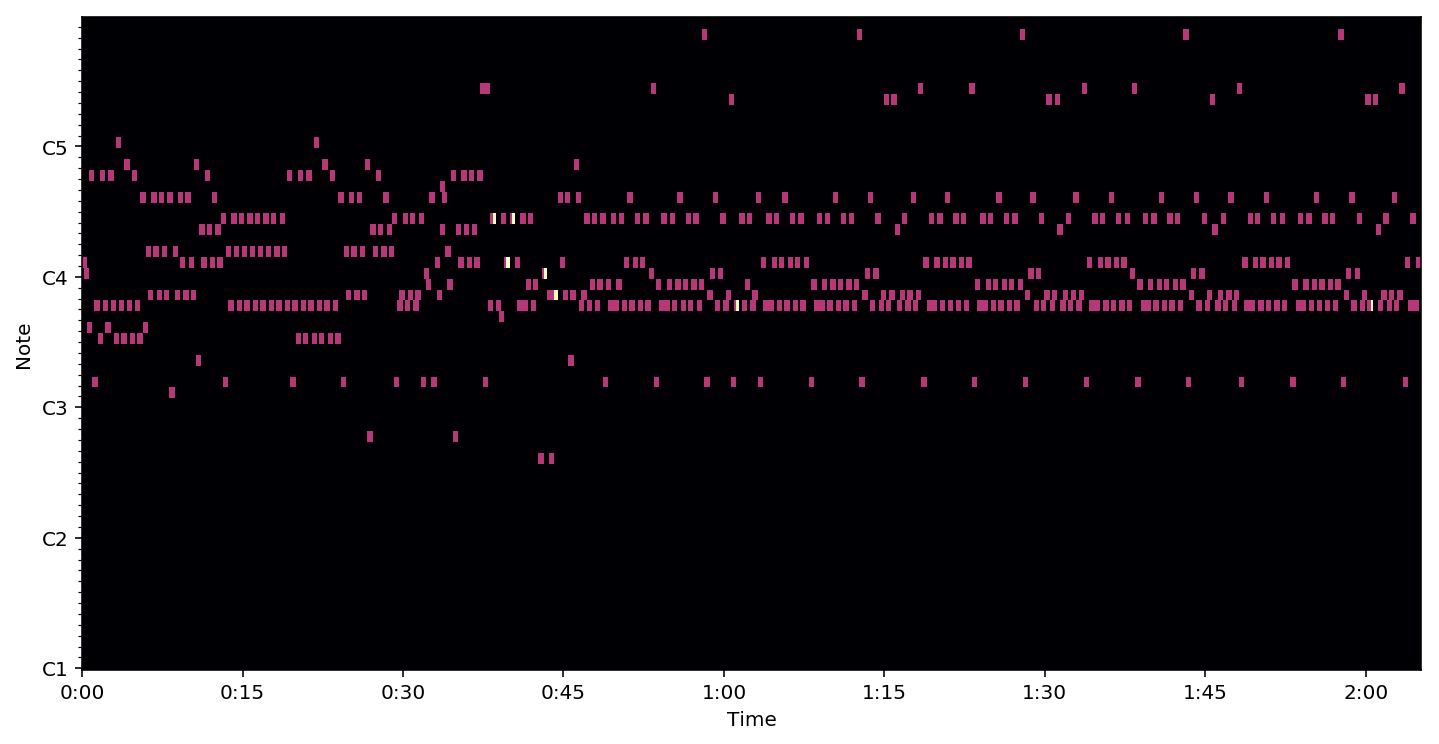

In [8]:
# midi_file = 'output/201803281154-100-lstm_midi.mid'
instrument_dict,pm = analyze_midi(midi_file)
ipd.Audio(pm.synthesize(fs=fs), rate=rate)

In [10]:
output_notes

[<music21.note.Note C#>,
 <music21.note.Note C>,
 <music21.note.Note G>,
 <music21.note.Note A>,
 <music21.note.Note D>,
 <music21.note.Note A>,
 <music21.note.Note F#>,
 <music21.note.Note A>,
 <music21.note.Note A>,
 <music21.note.Note G>,
 <music21.note.Note A>,
 <music21.note.Note A>,
 <music21.note.Note F#>,
 <music21.note.Note C>,
 <music21.note.Note A>,
 <music21.note.Note F#>,
 <music21.note.Note B->,
 <music21.note.Note A>,
 <music21.note.Note F#>,
 <music21.note.Note A>,
 <music21.note.Note A>,
 <music21.note.Note F#>,
 <music21.note.Note G>,
 <music21.note.Note G>,
 <music21.note.Note D>,
 <music21.note.Note B->,
 <music21.note.Note G>,
 <music21.note.Note D>,
 <music21.note.Note B->,
 <music21.note.Note G>,
 <music21.note.Note D>,
 <music21.note.Note B->,
 <music21.note.Note G>,
 <music21.note.Note C#>,
 <music21.note.Note D>,
 <music21.note.Note B->,
 <music21.note.Note G>,
 <music21.note.Note C#>,
 <music21.note.Note B->,
 <music21.note.Note G>,
 <music21.note.Note C#>,
 

In [11]:
from music21 import *
us = environment.UserSettings()
us.create()

In [12]:
for key in sorted(us.keys()):
    print(key)

autoDownload
braillePath
debug
directoryScratch
graphicsPath
ipythonShowFormat
lilypondBackend
lilypondFormat
lilypondPath
lilypondVersion
localCorporaSettings
localCorpusPath
localCorpusSettings
manualCoreCorpusPath
midiPath
musescoreDirectPNGPath
musicxmlPath
pdfPath
showFormat
vectorPath
warnings
writeFormat
